<center>
##IFT 6135 : Representation Learning 
##Winter 2018
  
# ASSIGNMENT - 1 : PROGRAMMING PART
# Problem (3) : Kaggle Cats vs Dogs  




Submitted by 

___________________________________________________



## PRAVISH SAINATH
####20125633
####M.Sc. Informatique
####Université de Montréal


#Section 1 : SETUP ✂ ✍ 📌

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Step [1] : Kaggle Setup
Generate an API token from Kaggle and upload it when prompted by the cell

**NOTE : The file should be named as *kaggle.json* **

In [0]:
DRIVE_DIRECTORY = '/content/gdrive/My Drive/Kaggle-IFT6135'
DRIVE_PATH = DRIVE_DIRECTORY + '/%s'

In [0]:
# Installing kaggle CLI
!pip install -q kaggle

# Move auth file to appropriate location to authorize kaggle commands
!mkdir -p ~/.kaggle
!cp '/content/gdrive/My Drive/Kaggle-IFT6135/credentials/kaggle.json' ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

## Step [2] : Dataset Download

In [7]:
# Download dataset of this competition from Kaggle
!kaggle competitions download -c ift6135h19

  0% 0.00/42.9k [00:00<?, ?B/s]
100% 42.9k/42.9k [00:00<00:00, 42.0MB/s]
 66% 5.00M/7.63M [00:00<00:00, 8.42MB/s]
100% 7.63M/7.63M [00:00<00:00, 12.0MB/s]
 82% 25.0M/30.6M [00:00<00:00, 11.8MB/s]
100% 30.6M/30.6M [00:00<00:00, 41.9MB/s]


In [8]:
# Unzip and move train and test datasets to ./data 
!mkdir -p data
!unzip trainset.zip -d data
!unzip testset.zip -d data

# Move submission file to ./results
!mkdir -p results
!mv sample_submission.csv results/

# Create directory ./models to store trained models 
!mkdir -p models

Archive:  trainset.zip
   creating: data/trainset/
   creating: data/trainset/Cat/
  inflating: data/trainset/Cat/63.Cat.jpg  
  inflating: data/trainset/Cat/1983.Cat.jpg  
  inflating: data/trainset/Cat/2370.Cat.jpg  
  inflating: data/trainset/Cat/7556.Cat.jpg  
  inflating: data/trainset/Cat/5336.Cat.jpg  
  inflating: data/trainset/Cat/2208.Cat.jpg  
  inflating: data/trainset/Cat/6124.Cat.jpg  
  inflating: data/trainset/Cat/3702.Cat.jpg  
  inflating: data/trainset/Cat/1162.Cat.jpg  
  inflating: data/trainset/Cat/4744.Cat.jpg  
  inflating: data/trainset/Cat/5326.Cat.jpg  
  inflating: data/trainset/Cat/1993.Cat.jpg  
  inflating: data/trainset/Cat/2360.Cat.jpg  
  inflating: data/trainset/Cat/73.Cat.jpg  
  inflating: data/trainset/Cat/7546.Cat.jpg  
  inflating: data/trainset/Cat/2.Cat.jpg  
  inflating: data/trainset/Cat/1172.Cat.jpg  
  inflating: data/trainset/Cat/4754.Cat.jpg  
  inflating: data/trainset/Cat/6134.Cat.jpg  
  inflating: data/trainset/Cat/2218.Cat.jpg  
  in

### Imports

In [0]:
# PyTorch imports

import torch

import torchvision
from torchvision import transforms, utils, datasets

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler


# Numpy and matplotlib


import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt


# For file operations
import os

# For logging metrics to csv file
import pandas as pd

## Step [3] : Data Preprocessing




In [0]:
def compute_mean_and_std(data_loader):

    mean = torch.zeros(3)
    std = torch.zeros(3)

    for inputs, targets in data_loader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(data_loader))
    std.div_(len(data_loader))
    return mean, std

In [0]:
def get_mean_and_std():
  data_loader = get_data_loader(root="data/trainset",batch_size=19999)

In [0]:
get_mean_and_std() # batch_size = len(data_loader)

(tensor([0.4897, 0.4547, 0.4160]), tensor([0.2521, 0.2451, 0.2473]))

In [0]:
def preprocessing_transform():
    return transforms.Compose([
#          transforms.RandomResizedCrop(32),
        transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
  transforms.Normalize((0.4897, 0.4547, 0.4160), (0.2521, 0.2451, 0.2473))
    ])  

## Step [4] : PyTorch Dataloder


In [0]:
#Constants

BATCH_SIZE = 512

#Device setting
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
def get_train_valid_loaders(root="data/trainset", batch_size=BATCH_SIZE, split_ratio = 0.7, transform = preprocessing_transform(), shuffle = True):
 
    train_dataset = datasets.ImageFolder(root=root , transform=transform)
    valid_dataset = datasets.ImageFolder(root=root , transform=transform)
    
    num_samples = len(train_dataset)
    indices = list(range(num_samples))
    split_index = int(np.floor(split_ratio * num_samples))
    
    if shuffle:
        np.random.seed(5)
        np.random.shuffle(indices)

    train_index, valid_index = indices[:split_index], indices[split_index:]
    train_sampler = SubsetRandomSampler(train_index)
    valid_sampler = SubsetRandomSampler(valid_index)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=1, pin_memory=True,
    )
    
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=1, pin_memory=True,
    )
    
    print(" Training set  : {} batches = {} samples".format(len(train_loader),len(train_index)))
    print("Validation set : {} batches = {} samples".format(len(valid_loader),len(valid_index)))
    
    return train_loader, valid_loader   

In [0]:
def get_data_loader(root="data/testset", transform = preprocessing_transform(), batch_size=BATCH_SIZE):

    dataset = datasets.ImageFolder(root=root , transform=transform)
    
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, num_workers=1, pin_memory=True,
    )
    
    return data_loader

In [0]:
def show_batch(batch):
    im = utils.make_grid(batch)
    plt.figure(figsize=(5,5))
    plt.grid(False)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

## Step [5] : Training




In [0]:
def evaluate_metrics(model,data_loader,criterion):
  
  correct = 0.
  total = 0.
  
  loss = 0.
  
  model.eval()
  with torch.no_grad():
    for data in data_loader:
      
      images, labels = data
      outputs = model(images.to(device))
      
      mini_batch_size = labels.size(0)
      
      loss += mini_batch_size * criterion(outputs, labels.to(device))
                
      _, predicted = torch.max(outputs.data, 1)
      total += mini_batch_size
      correct += (predicted == labels.to(device)).sum().item()
      
  loss = loss/total
  accuracy = correct/total  
  
  return loss, accuracy

In [0]:
def compute_accuracy(outputs,labels):
  _, predicted = torch.max(outputs.data, 1)
  return (predicted == labels).sum().item() / labels.size(0)

In [0]:
def compute_loss(outputs,labels,criterion):
  return criterion(outputs, labels)
  

In [0]:
def train(experiment_name, train_loader, valid_loader, model, optimizer, criterion, num_epochs,start_epoch):
        
    torch.cuda.manual_seed(10)
    
    model = model.to(device)
    criterion = criterion.to(device)
    #optimizer = optim.SGD(model.parameters(), lr=0.001) 
    

    train_accuracy = []
    valid_accuracy = []
    train_loss = []
    valid_loss = []
    
    state_buffer = []
    
    print("Training for epochs #", num_epochs)
    
    for epoch in range(start_epoch,start_epoch + num_epochs):
        # Training set    
            
        model.train()
        for i, data in enumerate(train_loader, 0):
            
            inputs, labels = data
            optimizer.zero_grad()
            
            
            
            outputs = model(inputs.to(device))
            
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()
            
            
        loss_metric, accuracy_metric = evaluate_metrics(model,train_loader,criterion)
        
        train_accuracy.append(accuracy_metric)
        train_loss.append(loss_metric)
        
        # Validation set 
        
        loss_metric, accuracy_metric = evaluate_metrics(model,valid_loader,criterion)
        
                
        valid_accuracy.append(accuracy_metric)
        valid_loss.append(loss_metric)
        
        
        print("======================================================================")
        print('Epoch:', epoch)
        print(' Training  :: Accuracy = %.4f, Loss = %.6f' % (train_accuracy[-1]*100, train_loss[-1]))
        print('Validation :: Accuracy = %.4f, Loss = %.6f' % (valid_accuracy[-1]*100, valid_loss[-1]))
        
        state = {
           "epoch" : epoch,
           "train_accuracy" : train_accuracy[-1]*100,
           "valid_accuracy" : valid_accuracy[-1]*100,
           "train_loss" : train_loss[-1],
           "valid_loss" : valid_loss[-1],            
        }
        
        state_buffer.append(state)
        
        if epoch%5 == 0 or epoch == num_epochs-1 :
          path = os.path.join("{}/models/{}".format(DRIVE_DIRECTORY,experiment_name), "{}-e{}.pth".format(experiment_name,epoch))
          torch.save(model.state_dict(), path)
          
          df = pd.DataFrame(state_buffer)
          
          state_file_name = '{}/results/{}.csv'.format(DRIVE_DIRECTORY,experiment_name)
          
          if not os.path.isfile(state_file_name):
            df.to_csv(state_file_name, index = False)
          else: 
            df.to_csv(state_file_name, mode='a', header=False, index = False)
                      
          state_buffer.clear()
          
        
    return model #, train_accuracy, train_loss, valid_accuracy, valid_loss   

## Step [6] : Neural Network Architecture (Model)




### Deep CNN

In [0]:
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5, padding=0) 
        self.conv2 = nn.Conv2d(64, 128, 5, padding=0)
        self.conv3 = nn.Conv2d(128, 256, 5, padding=0)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x))) 
        x = self.pool(F.relu(self.conv3(x)))
        print(x.shape)
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [0]:
class DeeperCNN(nn.Module):
    def __init__(self):
        super(DeeperCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=0) 
        self.conv2 = nn.Conv2d(64, 128, 3, padding=0)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=0)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=0)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 2 * 2, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x))) 
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 256 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### VGG Net

In [0]:

architecture = {
    11 : [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'P'],
    13 : [64, 64, 'P', 128, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'P'],
    16 : [64, 64, 'P', 128, 128, 'P', 256, 256, 256, 'P', 512, 512, 512, 'P', 512, 512, 512, 'P'],
    19 : [64, 64, 'P', 128, 128, 'P', 256, 256, 256, 256, 'P', 512, 512, 512, 512, 'P', 512, 512, 512, 512, 'P'],
}


class VGG(nn.Module):
    def __init__(self, num_layers):
        super(VGG, self).__init__()
        self.features = self._make_layers(architecture[num_layers])
        self.classifier = nn.Linear(2048, 2)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for out_channel in architecture:
            if out_channel == 'P':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, out_channel, kernel_size=3, padding=1),
                           nn.ReLU(inplace=True)]
                in_channels = out_channel
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)
      

### ResNet

In [0]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.conv2(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
      
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = self.conv3(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=2)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):

        out = F.relu(self.conv1(x))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
  
def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

In [0]:
def test_model(model,batch_size = BATCH_SIZE):
  x = torch.randn(batch_size,3,64,64)
  y = model(x)
  print(y.size())

In [0]:
test_model(ResNet34())

torch.Size([256, 3, 64, 64])
torch.Size([256, 64, 64, 64])
torch.Size([256, 64, 32, 32])
torch.Size([256, 128, 16, 16])
torch.Size([256, 256, 8, 8])
torch.Size([256, 512, 4, 4])
torch.Size([256, 512, 1, 1])
torch.Size([256, 512])
torch.Size([256, 2])


In [0]:
test_model(ResNet34())

torch.Size([256, 512, 4, 4])
torch.Size([256, 512, 1, 1])
torch.Size([256, 512])
torch.Size([256, 2])


In [0]:
test_model(VGG(19))

torch.Size([1024, 2])


In [31]:
VGG(11)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kern

In [0]:
class VGG6(nn.Module):
    def __init__(self):
        super(VGG6, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=0)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=0)
        
        self.conv3 = nn.Conv2d(64, 128, 3, padding=0)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=0)

        self.conv5 = nn.Conv2d(128, 256, 3, padding=0)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=0)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(256 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x)) 
        x = self.pool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x)) 
        x = self.pool(F.relu(self.conv6(x)))
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [0]:
test_model(VGG6())

torch.Size([8, 2])


In [0]:
def show_batch(batch):
    im = utils.make_grid(batch)
    plt.figure(figsize=(20,20))
    plt.grid(False)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

## Step [7] : Prediction
Using the trained model to make predictions of the test data and producing the submission file 




In [0]:
def predict_submission(model,name):
  
  test_loader = get_data_loader()
  label_dict = {0:'Cat', 1:'Dog'}

  predictions = []
  
  model.eval()
  with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
      test_pred = model(images.to(device))
      _, predicted = torch.max(test_pred.data, 1)
      predictions.extend(predicted)

  
  ordering = [str(i) for i in range(1,len(test_loader))]
  ordering.sort()
  
  ids = [int(id) for id in ordering]
  

  frame = pd.DataFrame(columns=['id','label'])
  frame['id'] = ids
  frame['label'] = [label_dict[p.item()] for p in predictions]

  
  new_frame = frame.copy()
  new_frame = new_frame.sort_values(by='id')    
  
  file = new_frame.to_csv('results/%s.csv' % name, index=False)
  
  return new_frame
  
  

## Step [8] : Experiment Setup
Putting it all together




In [0]:
def run_experiment(name, learning_rate, num_epochs, model, batch_size = BATCH_SIZE,start_epoch=0):
  
  experiment_name = "%s[lr=%.3f][e=%d][b=%d]" % (name,learning_rate,num_epochs,batch_size)
  
  print("Running experiment : ",experiment_name)
  
  model_directory_name = "{}/models/{}".format(DRIVE_DIRECTORY,experiment_name)
  
  if not os.path.exists(model_directory_name):
        os.mkdir(model_directory_name)
  
  train_loader, valid_loader = get_train_valid_loaders(batch_size = batch_size)
  
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=learning_rate)     
  
  model = train(experiment_name, train_loader, valid_loader, model, optimizer, criterion, num_epochs,start_epoch)

  return model

# Section 2 : EXPERIMENTS ♞ 🎲🕹

**Hyperparameters:**

- Architectural (Based on Model structure) :
    * Number of (Conv, Pool, Fc) layers
    * Number of filters in each Conv layer
    * Size of filter in each Conv layer
    * Size of filter in each Pooling layer
    * Number of neurons in each Fc layer 
    * Type of Pooling (Avg/Sum/Max) - *Max best*
    * Activation function of the hidden (Conv, Fc) layer - *ReLU best* 
 
 
 - Experimental (Based on Experiment settings):
    * Batch size of training dataset
    * Number of training epochs
    * Learning rate (optimizer)

## Experiment [1] : 2 Layer CNN
64 Conv 3x3 → MaxPool 2x2 → 64 Conv 3x3 → MaxPool 2x2 → Fc 64  → Fc 2 

## Experiment [2] : 3 Layer CNN
64 Conv 5x5 → MaxPool 2x2 → 128 Conv 5x5 → MaxPool 2x2 → 256 Conv 5x5 → MaxPool 2x2 → Fc 4096  → Fc 64  → Fc 2 

In [0]:
model_3cnn = run_experiment("3LayerCNN",0.01,120,DeepCNN(),4)

 Training set  : 3500 batches = 13998 samples
Validation set : 1500 batches = 6000 samples
Training for epochs # 120
Epoch: 0
Training  :: Accuracy = 52.61465923703387, Loss = 0.7183345556259155
Validation :: Accuracy 52.68333333333334, Loss = 0.6710860729217529
Epoch: 1
Training  :: Accuracy = 59.058436919559945, Loss = 0.5489740371704102
Validation :: Accuracy 57.99999999999999, Loss = 0.508837103843689
Epoch: 2
Training  :: Accuracy = 66.25946563794828, Loss = 0.31809088587760925
Validation :: Accuracy 70.26666666666667, Loss = 0.35095810890197754
Epoch: 3
Training  :: Accuracy = 71.57451064437777, Loss = 0.9356390237808228
Validation :: Accuracy 72.6, Loss = 0.3240104019641876
Epoch: 4
Training  :: Accuracy = 75.58222603229032, Loss = 0.5538420677185059
Validation :: Accuracy 76.38333333333334, Loss = 0.4597163200378418
Epoch: 5
Training  :: Accuracy = 78.8755536505215, Loss = 0.09802687168121338
Validation :: Accuracy 76.51666666666667, Loss = 0.6656480431556702
Epoch: 6
Training 

In [0]:
#Early stopping previous model
model_3cnn = run_experiment("3LayerCNN",0.01,81,DeepCNN(),4) 

 Training set  : 3500 batches = 13998 samples
Validation set : 1500 batches = 6000 samples
Training for epochs # 81
Epoch: 0
 Training  :: Accuracy = 53.8363, Loss = 1.076494
Validation :: Accuracy = 61.0833, Loss = 0.651975
Epoch: 1
 Training  :: Accuracy = 61.5016, Loss = 0.550973
Validation :: Accuracy = 65.2333, Loss = 0.540904
Epoch: 2
 Training  :: Accuracy = 68.6312, Loss = 0.883165
Validation :: Accuracy = 71.9500, Loss = 0.521823
Epoch: 3
 Training  :: Accuracy = 73.3533, Loss = 1.014807
Validation :: Accuracy = 75.9500, Loss = 0.334876
Epoch: 4
 Training  :: Accuracy = 76.6395, Loss = 0.329460
Validation :: Accuracy = 77.5000, Loss = 0.260153
Epoch: 5
 Training  :: Accuracy = 80.3829, Loss = 0.683952
Validation :: Accuracy = 77.5500, Loss = 0.565831
Epoch: 6
 Training  :: Accuracy = 82.3546, Loss = 0.281664
Validation :: Accuracy = 77.4333, Loss = 0.145132
Epoch: 7
 Training  :: Accuracy = 85.4336, Loss = 1.010675
Validation :: Accuracy = 79.2833, Loss = 0.046470
Epoch: 8
 Tr

In [0]:
model_another3cnn = run_experiment("3LayerCNN",0.001,100,DeepCNN(),4)

 Training set  : 3500 batches = 13998 samples
Validation set : 1500 batches = 6000 samples
Training for epochs # 100
Epoch: 0
 Training  :: Accuracy = 51.8717, Loss = 0.694133
Validation :: Accuracy = 50.8000, Loss = 0.684953
Epoch: 1
 Training  :: Accuracy = 54.3935, Loss = 0.697668
Validation :: Accuracy = 54.3000, Loss = 0.697323
Epoch: 2
 Training  :: Accuracy = 55.0793, Loss = 0.716697
Validation :: Accuracy = 53.5667, Loss = 0.680369
Epoch: 3
 Training  :: Accuracy = 56.6652, Loss = 0.639825
Validation :: Accuracy = 55.2000, Loss = 0.747536
Epoch: 4
 Training  :: Accuracy = 56.6224, Loss = 0.723493
Validation :: Accuracy = 56.5167, Loss = 0.737837
Epoch: 5
 Training  :: Accuracy = 58.4726, Loss = 0.634995
Validation :: Accuracy = 59.8333, Loss = 0.723473
Epoch: 6
 Training  :: Accuracy = 60.4301, Loss = 0.615860
Validation :: Accuracy = 62.3500, Loss = 0.578171
Epoch: 7
 Training  :: Accuracy = 62.3089, Loss = 0.826796
Validation :: Accuracy = 61.7500, Loss = 0.579693
Epoch: 8
 T

## Experiment [3] : VGG-11

In [0]:
model = run_experiment("VGG6",0.01,80)

Running experiment :  VGG6|0.010|80
 Training set  : 3500 batches = 13998 samples
Validation set : 1500 batches = 6000 samples
Training for epochs # 80
Epoch: 0
 Training  :: Accuracy = 49.2856, Loss = 0.732399
Validation :: Accuracy = 49.9333, Loss = 0.710184
Epoch: 1
 Training  :: Accuracy = 49.4428, Loss = 0.693676
Validation :: Accuracy = 50.0667, Loss = 0.729165
Epoch: 2
 Training  :: Accuracy = 49.2713, Loss = 0.693084
Validation :: Accuracy = 49.9333, Loss = 0.695671
Epoch: 3
 Training  :: Accuracy = 49.9071, Loss = 0.692339
Validation :: Accuracy = 53.6333, Loss = 0.692197
Epoch: 4
 Training  :: Accuracy = 50.8716, Loss = 0.694422
Validation :: Accuracy = 49.9333, Loss = 0.640997
Epoch: 5
 Training  :: Accuracy = 51.2573, Loss = 0.689345
Validation :: Accuracy = 54.0500, Loss = 0.698831
Epoch: 6
 Training  :: Accuracy = 53.8648, Loss = 0.539323
Validation :: Accuracy = 50.1500, Loss = 0.606275
Epoch: 7
 Training  :: Accuracy = 58.0940, Loss = 0.713583
Validation :: Accuracy = 6

In [0]:
model = run_experiment("VGG6",0.01,80,batch_size = 16)

Running experiment :  VGG6[lr=0.010][e=80][b=16]
 Training set  : 3500 batches = 13998 samples
Validation set : 1500 batches = 6000 samples
Training for epochs # 80
Epoch: 0
 Training  :: Accuracy = 50.3501, Loss = 0.693663
Validation :: Accuracy = 50.0667, Loss = 0.693902
Epoch: 1
 Training  :: Accuracy = 49.8000, Loss = 0.693466
Validation :: Accuracy = 49.9333, Loss = 0.702043
Epoch: 2
 Training  :: Accuracy = 50.2500, Loss = 0.694387
Validation :: Accuracy = 49.9333, Loss = 0.696275
Epoch: 3
 Training  :: Accuracy = 50.9287, Loss = 0.692082
Validation :: Accuracy = 50.0667, Loss = 0.694905
Epoch: 4
 Training  :: Accuracy = 51.9646, Loss = 0.701430
Validation :: Accuracy = 54.7167, Loss = 0.694081
Epoch: 5
 Training  :: Accuracy = 55.0007, Loss = 0.710916
Validation :: Accuracy = 59.5833, Loss = 0.656108
Epoch: 6
 Training  :: Accuracy = 60.7587, Loss = 0.670288
Validation :: Accuracy = 64.5833, Loss = 0.602925
Epoch: 7
 Training  :: Accuracy = 64.9879, Loss = 0.241625
Validation ::

In [0]:
model = run_experiment("VGG6",0.01,80,batch_size = 32)

Running experiment :  VGG6[lr=0.010][e=80][b=32]
 Training set  : 3500 batches = 13998 samples
Validation set : 1500 batches = 6000 samples
Training for epochs # 80
Epoch: 0
 Training  :: Accuracy = 49.8428, Loss = 0.708470
Validation :: Accuracy = 49.9333, Loss = 0.697663
Epoch: 1
 Training  :: Accuracy = 50.1000, Loss = 0.678890
Validation :: Accuracy = 49.9333, Loss = 0.671949
Epoch: 2
 Training  :: Accuracy = 50.9430, Loss = 0.749423
Validation :: Accuracy = 49.9333, Loss = 0.736147
Epoch: 3
 Training  :: Accuracy = 52.1717, Loss = 0.755288
Validation :: Accuracy = 53.5833, Loss = 0.686159
Epoch: 4
 Training  :: Accuracy = 55.8937, Loss = 0.727695
Validation :: Accuracy = 60.7167, Loss = 0.749847
Epoch: 5
 Training  :: Accuracy = 60.4729, Loss = 0.430329
Validation :: Accuracy = 63.0667, Loss = 0.495942
Epoch: 6
 Training  :: Accuracy = 64.0234, Loss = 0.688795
Validation :: Accuracy = 65.6500, Loss = 0.416904
Epoch: 7
 Training  :: Accuracy = 66.6024, Loss = 0.876502
Validation ::

In [0]:
model = run_experiment("VGG6",0.01,80,batch_size = 64)

Running experiment :  VGG6[lr=0.010][e=80][b=64]
 Training set  : 3500 batches = 13998 samples
Validation set : 1500 batches = 6000 samples
Training for epochs # 80
Epoch: 0
 Training  :: Accuracy = 49.6214, Loss = 0.707799
Validation :: Accuracy = 50.0667, Loss = 0.693259
Epoch: 1
 Training  :: Accuracy = 50.0000, Loss = 0.693320
Validation :: Accuracy = 49.9333, Loss = 0.678048
Epoch: 2
 Training  :: Accuracy = 49.6357, Loss = 0.704137
Validation :: Accuracy = 49.8333, Loss = 0.696295
Epoch: 3
 Training  :: Accuracy = 50.6287, Loss = 0.695374
Validation :: Accuracy = 50.0667, Loss = 0.695568
Epoch: 4
 Training  :: Accuracy = 53.3362, Loss = 0.660085
Validation :: Accuracy = 50.0000, Loss = 0.644635
Epoch: 5
 Training  :: Accuracy = 57.5511, Loss = 0.856173
Validation :: Accuracy = 61.6333, Loss = 0.739102


In [0]:
model = VGG()
model.load_state_dict(torch.load('models/VGG6|0.010|80/VGG6|0.010|80-e79.pth'))
model = run_experiment("VGG6-Further-More",0.001,60,model)

Running experiment :  VGG6-Further-More[lr=0.001][e=60][b=4]
 Training set  : 3500 batches = 13998 samples
Validation set : 1500 batches = 6000 samples
Training for epochs # 60
Epoch: 0
 Training  :: Accuracy = 99.9571, Loss = 0.000001
Validation :: Accuracy = 81.7333, Loss = 0.218004
Epoch: 1
 Training  :: Accuracy = 99.9428, Loss = 0.000009
Validation :: Accuracy = 81.7333, Loss = 0.283487
Epoch: 2
 Training  :: Accuracy = 99.9643, Loss = 0.000000
Validation :: Accuracy = 81.7167, Loss = 8.153759
Epoch: 3
 Training  :: Accuracy = 99.9500, Loss = 0.000018
Validation :: Accuracy = 81.7167, Loss = 0.000085
Epoch: 4
 Training  :: Accuracy = 99.9643, Loss = 0.000000
Validation :: Accuracy = 81.7167, Loss = 0.000000
Epoch: 5
 Training  :: Accuracy = 99.9428, Loss = 0.000108
Validation :: Accuracy = 81.7333, Loss = 8.444151
Epoch: 6
 Training  :: Accuracy = 99.9643, Loss = 0.000000
Validation :: Accuracy = 81.7000, Loss = 0.000000
Epoch: 7
 Training  :: Accuracy = 99.9643, Loss = 0.000000
V

In [0]:
model

VGG(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

In [0]:
model = run_experiment("VGG6-Further",0.001,40,model)

Running experiment :  VGG6-Further|0.001|40
 Training set  : 3500 batches = 13998 samples
Validation set : 1500 batches = 6000 samples
Training for epochs # 40
Epoch: 0
 Training  :: Accuracy = 50.0572, Loss = 0.692866
Validation :: Accuracy = 49.9333, Loss = 0.695952
Epoch: 1
 Training  :: Accuracy = 49.9071, Loss = 0.681948
Validation :: Accuracy = 49.9333, Loss = 0.693165
Epoch: 2
 Training  :: Accuracy = 49.9500, Loss = 0.693091
Validation :: Accuracy = 50.0667, Loss = 0.693048
Epoch: 3
 Training  :: Accuracy = 49.7928, Loss = 0.692923
Validation :: Accuracy = 50.0500, Loss = 0.693021
Epoch: 4
 Training  :: Accuracy = 49.9428, Loss = 0.693219
Validation :: Accuracy = 49.9333, Loss = 0.694930
Epoch: 5
 Training  :: Accuracy = 50.3286, Loss = 0.692970
Validation :: Accuracy = 50.2167, Loss = 0.692547
Epoch: 6
 Training  :: Accuracy = 50.4572, Loss = 0.684119
Validation :: Accuracy = 49.9333, Loss = 0.688282
Epoch: 7
 Training  :: Accuracy = 50.1000, Loss = 0.696794
Validation :: Accu

KeyboardInterrupt: ignored

## Experiment [4] : VGG-13

In [0]:
model = run_experiment("VGG11",0.01,100,VGG_Variant('VGG13'))

Running experiment :  VGG13[lr=0.010][e=100][b=1024]
 Training set  : 14 batches = 13998 samples
Validation set : 6 batches = 6000 samples
Training for epochs # 100
Epoch: 0
 Training  :: Accuracy = 49.9714, Loss = 0.693397
Validation :: Accuracy = 50.0667, Loss = 0.693435
Epoch: 1
 Training  :: Accuracy = 49.9714, Loss = 0.692884
Validation :: Accuracy = 50.0667, Loss = 0.693543
Epoch: 2
 Training  :: Accuracy = 49.9714, Loss = 0.692905
Validation :: Accuracy = 50.0667, Loss = 0.692980
Epoch: 3
 Training  :: Accuracy = 49.9714, Loss = 0.693302
Validation :: Accuracy = 50.0667, Loss = 0.693108
Epoch: 4
 Training  :: Accuracy = 49.9714, Loss = 0.693206
Validation :: Accuracy = 50.0667, Loss = 0.693388
Epoch: 5
 Training  :: Accuracy = 49.9714, Loss = 0.693304
Validation :: Accuracy = 50.0667, Loss = 0.693255
Epoch: 6
 Training  :: Accuracy = 49.9714, Loss = 0.693115
Validation :: Accuracy = 50.0667, Loss = 0.693385
Epoch: 7
 Training  :: Accuracy = 49.9714, Loss = 0.693037
Validation ::

KeyboardInterrupt: ignored

In [0]:

model = run_experiment("VGG11",0.01,80,VGG_Variant('VGG11'))

Running experiment :  VGG11[lr=0.010][e=80][b=4]
 Training set  : 3500 batches = 13998 samples
Validation set : 1500 batches = 6000 samples
Training for epochs # 80
Epoch: 0
 Training  :: Accuracy = 50.2429, Loss = 0.677976
Validation :: Accuracy = 50.0667, Loss = 0.693009
Epoch: 1
 Training  :: Accuracy = 52.5361, Loss = 0.412638
Validation :: Accuracy = 50.1500, Loss = 0.935216
Epoch: 2
 Training  :: Accuracy = 62.3946, Loss = 0.316136
Validation :: Accuracy = 65.7833, Loss = 0.739824
Epoch: 3
 Training  :: Accuracy = 67.2953, Loss = 0.427524
Validation :: Accuracy = 64.0333, Loss = 1.521453
Epoch: 4
 Training  :: Accuracy = 71.3888, Loss = 0.236996
Validation :: Accuracy = 75.0500, Loss = 0.525941
Epoch: 5
 Training  :: Accuracy = 75.8323, Loss = 0.102152
Validation :: Accuracy = 74.6667, Loss = 0.382953
Epoch: 6
 Training  :: Accuracy = 79.7042, Loss = 0.021723
Validation :: Accuracy = 80.6000, Loss = 0.352603
Epoch: 7
 Training  :: Accuracy = 81.9474, Loss = 1.071277
Validation ::

In [0]:

model13 = run_experiment("VGG13",0.01,80,VGG_Variant('VGG13'))

Running experiment :  VGG13[lr=0.010][e=80][b=4]
 Training set  : 3500 batches = 13998 samples
Validation set : 1500 batches = 6000 samples
Training for epochs # 80
Epoch: 0
 Training  :: Accuracy = 49.3571, Loss = 0.693534
Validation :: Accuracy = 50.0667, Loss = 0.707947
Epoch: 1
 Training  :: Accuracy = 50.0071, Loss = 0.693151
Validation :: Accuracy = 49.9333, Loss = 0.690437
Epoch: 2
 Training  :: Accuracy = 50.4501, Loss = 0.695401
Validation :: Accuracy = 49.9333, Loss = 0.728017
Epoch: 3
 Training  :: Accuracy = 50.2858, Loss = 0.693622
Validation :: Accuracy = 49.9333, Loss = 0.665395
Epoch: 4
 Training  :: Accuracy = 50.7787, Loss = 0.677805
Validation :: Accuracy = 50.0667, Loss = 0.703752
Epoch: 5
 Training  :: Accuracy = 50.4286, Loss = 0.694092
Validation :: Accuracy = 49.9333, Loss = 0.672848
Epoch: 6
 Training  :: Accuracy = 50.3786, Loss = 0.709847
Validation :: Accuracy = 49.9333, Loss = 0.693144
Epoch: 7
 Training  :: Accuracy = 50.3215, Loss = 0.718384
Validation ::

## Experiment [5] : Submitted model VGG-11 




In [0]:

model11 = run_experiment("VGG11",0.01,80,VGG_Variant('VGG11'),512)

Running experiment :  VGG11[lr=0.010][e=80][b=512]
 Training set  : 3500 batches = 13998 samples
Validation set : 1500 batches = 6000 samples
Training for epochs # 80
Epoch: 0
 Training  :: Accuracy = 50.4644, Loss = 0.695766
Validation :: Accuracy = 49.9333, Loss = 0.680853
Epoch: 1
 Training  :: Accuracy = 52.4361, Loss = 0.732342
Validation :: Accuracy = 51.0000, Loss = 0.641467
Epoch: 2
 Training  :: Accuracy = 60.9087, Loss = 0.946317
Validation :: Accuracy = 65.5667, Loss = 0.863672
Epoch: 3
 Training  :: Accuracy = 66.7524, Loss = 0.693482
Validation :: Accuracy = 69.4167, Loss = 0.991932
Epoch: 4
 Training  :: Accuracy = 71.5888, Loss = 0.501538
Validation :: Accuracy = 71.6667, Loss = 0.812860
Epoch: 5
 Training  :: Accuracy = 74.9821, Loss = 0.139154
Validation :: Accuracy = 77.8333, Loss = 0.647156
Epoch: 6
 Training  :: Accuracy = 78.8898, Loss = 0.027084
Validation :: Accuracy = 81.1833, Loss = 0.298712
Epoch: 7
 Training  :: Accuracy = 81.5188, Loss = 0.896205
Validation 

In [0]:
torch.cuda.empty_cache()


In [0]:
f1, f2 = predict(model11,"vgg_13")

In [0]:
model19 = run_experiment("VGG19",0.001,80,VGG_Variant('VGG19'))

Running experiment :  VGG19[lr=0.001][e=80][b=1024]
 Training set  : 14 batches = 13998 samples
Validation set : 6 batches = 6000 samples
Training for epochs # 80
Epoch: 0
 Training  :: Accuracy = 50.0286, Loss = 0.693162
Validation :: Accuracy = 49.9333, Loss = 0.693278
Epoch: 1
 Training  :: Accuracy = 50.0286, Loss = 0.693198
Validation :: Accuracy = 49.9333, Loss = 0.693149
Epoch: 2
 Training  :: Accuracy = 50.0286, Loss = 0.693180
Validation :: Accuracy = 49.9333, Loss = 0.693121
Epoch: 3
 Training  :: Accuracy = 50.0286, Loss = 0.693043
Validation :: Accuracy = 49.9333, Loss = 0.693187


Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: ignored

In [0]:
model_16 = run_experiment("VGG16",0.1,80,VGG_Variant('VGG16'))

Running experiment :  VGG16[lr=0.100][e=80][b=512]
 Training set  : 28 batches = 13998 samples
Validation set : 12 batches = 6000 samples
Training for epochs # 80
Epoch: 0
 Training  :: Accuracy = 49.7571, Loss = 0.693067
Validation :: Accuracy = 49.9333, Loss = 0.693555
Epoch: 1
 Training  :: Accuracy = 49.8143, Loss = 0.692939
Validation :: Accuracy = 50.0667, Loss = 0.692058
Epoch: 2
 Training  :: Accuracy = 49.6142, Loss = 0.693249
Validation :: Accuracy = 49.9333, Loss = 0.693222
Epoch: 3
 Training  :: Accuracy = 49.0141, Loss = 0.693187
Validation :: Accuracy = 49.9333, Loss = 0.693059
Epoch: 4
 Training  :: Accuracy = 49.9428, Loss = 0.693796
Validation :: Accuracy = 49.9333, Loss = 0.693161
Epoch: 5
 Training  :: Accuracy = 50.4286, Loss = 0.692554
Validation :: Accuracy = 50.0667, Loss = 0.693158
Epoch: 6
 Training  :: Accuracy = 49.9714, Loss = 0.693339
Validation :: Accuracy = 50.0667, Loss = 0.693177
Epoch: 7
 Training  :: Accuracy = 49.4142, Loss = 0.693629
Validation :: A

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: ignored

In [0]:
model_vgg13 = run_experiment("VGG13",0.1,351,VGG_Variant('VGG13'))

Running experiment :  VGG13[lr=0.100][e=351][b=256]
 Training set  : 55 batches = 13998 samples
Validation set : 24 batches = 6000 samples
Training for epochs # 351
Epoch: 0
 Training  :: Accuracy = 50.0286, Loss = 0.693127
Validation :: Accuracy = 49.9333, Loss = 0.693146
Epoch: 1
 Training  :: Accuracy = 49.5999, Loss = 0.692755
Validation :: Accuracy = 49.9333, Loss = 0.693849
Epoch: 2
 Training  :: Accuracy = 50.1500, Loss = 0.694293
Validation :: Accuracy = 49.9333, Loss = 0.693065
Epoch: 3
 Training  :: Accuracy = 49.5714, Loss = 0.693101
Validation :: Accuracy = 50.0667, Loss = 0.693080
Epoch: 4
 Training  :: Accuracy = 49.7714, Loss = 0.694338
Validation :: Accuracy = 50.0667, Loss = 0.693083
Epoch: 5
 Training  :: Accuracy = 49.5428, Loss = 0.693735
Validation :: Accuracy = 49.9333, Loss = 0.693019
Epoch: 6
 Training  :: Accuracy = 49.2713, Loss = 0.692707
Validation :: Accuracy = 50.0667, Loss = 0.692755
Epoch: 7
 Training  :: Accuracy = 49.5714, Loss = 0.693256
Validation ::

In [0]:
model_vgg13 = run_experiment("VGG13",0.1,351,VGG_Variant('VGG13'))

Running experiment :  VGG13[lr=0.100][e=351][b=256]
 Training set  : 55 batches = 13998 samples
Validation set : 24 batches = 6000 samples
Training for epochs # 351
Epoch: 0
 Training  :: Accuracy = 49.4428, Loss = 0.694898
Validation :: Accuracy = 49.9333, Loss = 0.692903
Epoch: 1
 Training  :: Accuracy = 49.5999, Loss = 0.693229
Validation :: Accuracy = 49.9333, Loss = 0.693938
Epoch: 2
 Training  :: Accuracy = 50.2072, Loss = 0.693291
Validation :: Accuracy = 49.9333, Loss = 0.692677
Epoch: 3
 Training  :: Accuracy = 50.0429, Loss = 0.693759
Validation :: Accuracy = 50.0667, Loss = 0.693085
Epoch: 4
 Training  :: Accuracy = 50.1715, Loss = 0.693272
Validation :: Accuracy = 49.9333, Loss = 0.694076
Epoch: 5
 Training  :: Accuracy = 50.1000, Loss = 0.694113
Validation :: Accuracy = 49.9333, Loss = 0.693283
Epoch: 6
 Training  :: Accuracy = 49.6714, Loss = 0.692979
Validation :: Accuracy = 49.9333, Loss = 0.693043
Epoch: 7
 Training  :: Accuracy = 50.0572, Loss = 0.691744
Validation ::

In [0]:
new_model_vgg13 = run_experiment("VGG13",0.01,50,model_vgg13)

Running experiment :  VGG13[lr=0.010][e=50][b=256]
 Training set  : 55 batches = 13998 samples
Validation set : 24 batches = 6000 samples
Training for epochs # 50
Epoch: 0
 Training  :: Accuracy = 52.4718, Loss = 0.690781
Validation :: Accuracy = 53.7333, Loss = 0.694515
Epoch: 1
 Training  :: Accuracy = 54.0863, Loss = 0.688097
Validation :: Accuracy = 55.2333, Loss = 0.684425
Epoch: 2
 Training  :: Accuracy = 54.6721, Loss = 0.696726
Validation :: Accuracy = 55.3167, Loss = 0.690250
Epoch: 3
 Training  :: Accuracy = 55.0650, Loss = 0.686112
Validation :: Accuracy = 55.3500, Loss = 0.700965
Epoch: 4
 Training  :: Accuracy = 55.5937, Loss = 0.685318
Validation :: Accuracy = 55.3833, Loss = 0.699487
Epoch: 5
 Training  :: Accuracy = 55.7508, Loss = 0.696076
Validation :: Accuracy = 55.8833, Loss = 0.687961
Epoch: 6
 Training  :: Accuracy = 56.0866, Loss = 0.681573
Validation :: Accuracy = 55.5000, Loss = 0.675131
Epoch: 7
 Training  :: Accuracy = 55.8223, Loss = 0.690226
Validation :: A

## Experiment [6] : VGG-11 with b = 512 



In [26]:
model_vgg_11 = run_experiment("VGG11",0.1,80,VGG(11),512)

Running experiment :  VGG11[lr=0.100][e=80][b=512]
 Training set  : 28 batches = 13998 samples
Validation set : 12 batches = 6000 samples
Training for epochs # 80
Epoch: 0
 Training  :: Accuracy = 49.9714, Loss = 0.693139
Validation :: Accuracy = 50.0667, Loss = 0.693131
Epoch: 1
 Training  :: Accuracy = 50.0286, Loss = 0.693107
Validation :: Accuracy = 49.9333, Loss = 0.693118
Epoch: 2
 Training  :: Accuracy = 49.9714, Loss = 0.693107
Validation :: Accuracy = 50.0667, Loss = 0.693101
Epoch: 3
 Training  :: Accuracy = 51.0573, Loss = 0.693056
Validation :: Accuracy = 50.9833, Loss = 0.693066
Epoch: 4
 Training  :: Accuracy = 50.0286, Loss = 0.693042
Validation :: Accuracy = 49.9333, Loss = 0.693060
Epoch: 5
 Training  :: Accuracy = 49.9714, Loss = 0.693061
Validation :: Accuracy = 50.0667, Loss = 0.693054
Epoch: 6
 Training  :: Accuracy = 50.0286, Loss = 0.692991
Validation :: Accuracy = 49.9333, Loss = 0.693015
Epoch: 7
 Training  :: Accuracy = 49.9714, Loss = 0.692964
Validation :: A

In [31]:
model_vgg_11_plus = run_experiment("VGG11",0.01,80,model_vgg_11,512)

Running experiment :  VGG11[lr=0.010][e=80][b=512]
 Training set  : 28 batches = 13998 samples
Validation set : 12 batches = 6000 samples
Training for epochs # 80
Epoch: 0
 Training  :: Accuracy = 65.8951, Loss = 0.619375
Validation :: Accuracy = 65.3333, Loss = 0.619440
Epoch: 1
 Training  :: Accuracy = 71.8245, Loss = 0.564333
Validation :: Accuracy = 71.2167, Loss = 0.565632
Epoch: 2
 Training  :: Accuracy = 71.6745, Loss = 0.563218
Validation :: Accuracy = 71.1333, Loss = 0.564926
Epoch: 3
 Training  :: Accuracy = 70.6458, Loss = 0.570854
Validation :: Accuracy = 70.0333, Loss = 0.572453
Epoch: 4
 Training  :: Accuracy = 70.7530, Loss = 0.569593
Validation :: Accuracy = 70.5500, Loss = 0.572886
Epoch: 5
 Training  :: Accuracy = 71.9603, Loss = 0.558740
Validation :: Accuracy = 71.9000, Loss = 0.558742
Epoch: 6
 Training  :: Accuracy = 71.7174, Loss = 0.560629
Validation :: Accuracy = 70.9333, Loss = 0.562832
Epoch: 7
 Training  :: Accuracy = 71.4888, Loss = 0.561015
Validation :: A

In [36]:
model_vgg_11_plus_plus = run_experiment("VGG11",0.01,100,model_vgg_11_plus,512,161)

Running experiment :  VGG11[lr=0.010][e=100][b=512]
 Training set  : 28 batches = 13998 samples
Validation set : 12 batches = 6000 samples
Training for epochs # 100
Epoch: 161
 Training  :: Accuracy = 79.7543, Loss = 0.439425
Validation :: Accuracy = 78.5833, Loss = 0.454630
Epoch: 162
 Training  :: Accuracy = 78.1112, Loss = 0.470852
Validation :: Accuracy = 76.4000, Loss = 0.493838
Epoch: 163
 Training  :: Accuracy = 77.4539, Loss = 0.481131
Validation :: Accuracy = 75.9667, Loss = 0.501759
Epoch: 164
 Training  :: Accuracy = 73.5891, Loss = 0.528065
Validation :: Accuracy = 72.1333, Loss = 0.546384
Epoch: 165
 Training  :: Accuracy = 81.0830, Loss = 0.421978
Validation :: Accuracy = 79.3333, Loss = 0.443859
Epoch: 166
 Training  :: Accuracy = 80.0900, Loss = 0.441307
Validation :: Accuracy = 78.0333, Loss = 0.465197
Epoch: 167
 Training  :: Accuracy = 79.1685, Loss = 0.448002
Validation :: Accuracy = 77.8833, Loss = 0.464145
Epoch: 168
 Training  :: Accuracy = 80.8115, Loss = 0.4268

In [37]:
model_vgg_11_plus_plus_plus = run_experiment("VGG11",0.001,100,model_vgg_11_plus_plus,512,261)

Running experiment :  VGG11[lr=0.001][e=100][b=512]
 Training set  : 28 batches = 13998 samples
Validation set : 12 batches = 6000 samples
Training for epochs # 100
Epoch: 261
 Training  :: Accuracy = 88.8413, Loss = 0.264625
Validation :: Accuracy = 84.9333, Loss = 0.349998
Epoch: 262
 Training  :: Accuracy = 89.0127, Loss = 0.262915
Validation :: Accuracy = 84.7500, Loss = 0.348257
Epoch: 263
 Training  :: Accuracy = 89.1413, Loss = 0.261685
Validation :: Accuracy = 84.7500, Loss = 0.348921
Epoch: 264
 Training  :: Accuracy = 89.3556, Loss = 0.258348
Validation :: Accuracy = 84.6000, Loss = 0.348498
Epoch: 265
 Training  :: Accuracy = 89.2056, Loss = 0.260324
Validation :: Accuracy = 84.8333, Loss = 0.347205
Epoch: 266
 Training  :: Accuracy = 89.3985, Loss = 0.257760
Validation :: Accuracy = 84.9500, Loss = 0.347557
Epoch: 267
 Training  :: Accuracy = 89.2770, Loss = 0.257593
Validation :: Accuracy = 85.2000, Loss = 0.346556
Epoch: 268
 Training  :: Accuracy = 89.2913, Loss = 0.2572

In [39]:
model_vgg_11_plus_plus_plus_plus = run_experiment("VGG11",0.01,100,model_vgg_11_plus_plus_plus,512,361)

Running experiment :  VGG11[lr=0.010][e=100][b=512]
 Training set  : 28 batches = 13998 samples
Validation set : 12 batches = 6000 samples
Training for epochs # 100
Epoch: 361
 Training  :: Accuracy = 73.5891, Loss = 0.536803
Validation :: Accuracy = 72.7167, Loss = 0.544023
Epoch: 362
 Training  :: Accuracy = 83.7048, Loss = 0.362264
Validation :: Accuracy = 81.1667, Loss = 0.415007
Epoch: 363
 Training  :: Accuracy = 83.1762, Loss = 0.381041
Validation :: Accuracy = 79.7000, Loss = 0.459023
Epoch: 364
 Training  :: Accuracy = 85.4979, Loss = 0.323256
Validation :: Accuracy = 81.5333, Loss = 0.416615
Epoch: 365
 Training  :: Accuracy = 82.8833, Loss = 0.379094
Validation :: Accuracy = 79.3500, Loss = 0.449159
Epoch: 366
 Training  :: Accuracy = 84.4835, Loss = 0.355654
Validation :: Accuracy = 80.3167, Loss = 0.428061
Epoch: 367
 Training  :: Accuracy = 84.0906, Loss = 0.352820
Validation :: Accuracy = 80.8833, Loss = 0.431600
Epoch: 368
 Training  :: Accuracy = 84.0692, Loss = 0.3559

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: ignored

In [24]:
model_vgg11 = run_experiment("VGG11",0.01,80,VGG(11),512)

Running experiment :  VGG11[lr=0.010][e=80][b=512]
 Training set  : 28 batches = 13998 samples
Validation set : 12 batches = 6000 samples
Training for epochs # 80
Epoch: 0
 Training  :: Accuracy = 50.0286, Loss = 0.693191
Validation :: Accuracy = 49.9333, Loss = 0.693212
Epoch: 1
 Training  :: Accuracy = 50.0286, Loss = 0.693175
Validation :: Accuracy = 49.9333, Loss = 0.693196
Epoch: 2
 Training  :: Accuracy = 50.0286, Loss = 0.693162
Validation :: Accuracy = 49.9333, Loss = 0.693178
Epoch: 3
 Training  :: Accuracy = 50.0286, Loss = 0.693150
Validation :: Accuracy = 49.9333, Loss = 0.693163
Epoch: 4
 Training  :: Accuracy = 50.0286, Loss = 0.693144
Validation :: Accuracy = 49.9333, Loss = 0.693158
Epoch: 5
 Training  :: Accuracy = 50.0286, Loss = 0.693135
Validation :: Accuracy = 49.9333, Loss = 0.693146
Epoch: 6
 Training  :: Accuracy = 50.0286, Loss = 0.693128
Validation :: Accuracy = 49.9333, Loss = 0.693139
Epoch: 7
 Training  :: Accuracy = 50.0286, Loss = 0.693124
Validation :: A

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: ignored

## Experiment [6] : ResNet-16

In [0]:
model_res34 = run_experiment("ResNet34",0.1,250,ResNet34())

Running experiment :  ResNet34[lr=0.100][e=250][b=256]
 Training set  : 55 batches = 13998 samples
Validation set : 24 batches = 6000 samples
Training for epochs # 250
Epoch: 0
 Training  :: Accuracy = 50.5144, Loss = 0.692917
Validation :: Accuracy = 49.9333, Loss = 0.692892
Epoch: 1
 Training  :: Accuracy = 50.7787, Loss = 0.693176
Validation :: Accuracy = 49.9667, Loss = 0.691209
Epoch: 2
 Training  :: Accuracy = 50.9216, Loss = 0.691625
Validation :: Accuracy = 57.3500, Loss = 0.693694
Epoch: 3
 Training  :: Accuracy = 53.3148, Loss = 0.690311
Validation :: Accuracy = 56.3000, Loss = 0.691266
Epoch: 4
 Training  :: Accuracy = 54.4292, Loss = 0.687674
Validation :: Accuracy = 51.3000, Loss = 0.686170
Epoch: 5
 Training  :: Accuracy = 55.3436, Loss = 0.681434
Validation :: Accuracy = 58.6000, Loss = 0.682685
Epoch: 6
 Training  :: Accuracy = 56.1223, Loss = 0.666959
Validation :: Accuracy = 56.9833, Loss = 0.667853
Epoch: 7
 Training  :: Accuracy = 56.2223, Loss = 0.682470
Validation

KeyboardInterrupt: ignored

In [0]:
model_res34 = ResNet34()
model_res34.load_state_dict(torch.load(DRIVE_DIRECTORY + '/models/ResNet34[lr=0.100][e=250][b=256]/ResNet34[lr=0.100][e=250][b=256]-e30.pth'))
model_res34_01 = run_experiment("ResNet34",0.01,100,model_res34)

Running experiment :  ResNet34[lr=0.010][e=100][b=256]
 Training set  : 55 batches = 13998 samples
Validation set : 24 batches = 6000 samples
Training for epochs # 100
Epoch: 0
 Training  :: Accuracy = 71.4316, Loss = 0.618177
Validation :: Accuracy = 70.6333, Loss = 0.532933
Epoch: 1
 Training  :: Accuracy = 71.6174, Loss = 0.566364
Validation :: Accuracy = 70.7833, Loss = 0.580226
Epoch: 2
 Training  :: Accuracy = 72.1675, Loss = 0.539457
Validation :: Accuracy = 71.1333, Loss = 0.554234
Epoch: 3
 Training  :: Accuracy = 71.8888, Loss = 0.576821
Validation :: Accuracy = 71.1000, Loss = 0.503410
Epoch: 4
 Training  :: Accuracy = 72.3389, Loss = 0.558859
Validation :: Accuracy = 71.0667, Loss = 0.614639
Epoch: 5
 Training  :: Accuracy = 72.1246, Loss = 0.541494
Validation :: Accuracy = 70.9167, Loss = 0.647526
Epoch: 6
 Training  :: Accuracy = 72.4604, Loss = 0.540075
Validation :: Accuracy = 70.8833, Loss = 0.635351
Epoch: 7
 Training  :: Accuracy = 72.5818, Loss = 0.485025
Validation

In [0]:
model_res34_02 = run_experiment("ResNet34",0.01,150,model_res34_01)

Running experiment :  ResNet34[lr=0.010][e=150][b=256]
 Training set  : 55 batches = 13998 samples
Validation set : 24 batches = 6000 samples
Training for epochs # 150
Epoch: 0
 Training  :: Accuracy = 82.9904, Loss = 0.373813
Validation :: Accuracy = 79.7500, Loss = 0.487173
Epoch: 1
 Training  :: Accuracy = 82.3903, Loss = 0.296967
Validation :: Accuracy = 81.4167, Loss = 0.380946
Epoch: 2
 Training  :: Accuracy = 82.4904, Loss = 0.314218
Validation :: Accuracy = 80.9000, Loss = 0.509861
Epoch: 3
 Training  :: Accuracy = 83.5619, Loss = 0.416221
Validation :: Accuracy = 80.4667, Loss = 0.351952
Epoch: 4
 Training  :: Accuracy = 83.5405, Loss = 0.338354
Validation :: Accuracy = 74.8500, Loss = 0.483378
Epoch: 5
 Training  :: Accuracy = 83.1190, Loss = 0.344636
Validation :: Accuracy = 80.5500, Loss = 0.464855
Epoch: 6
 Training  :: Accuracy = 83.8977, Loss = 0.425812
Validation :: Accuracy = 79.0500, Loss = 0.414713
Epoch: 7
 Training  :: Accuracy = 84.2049, Loss = 0.434883
Validation

In [0]:
trained_model = VGG(11)
trained_model.load_state_dict(torch.load('VGG11[lr=0.010][e=80][b=4]-e80.pth'))

In [0]:
def predict_validation(model,case='mismatch'):
  
  _, valid_loader = get_train_valid_loaders(batch_size=1, transform = transforms.ToTensor())

  predictions = []
  
  model.eval()
  with torch.no_grad():
    for i, (images, labels) in enumerate(valid_loader):
      test_pred = model(images)
      
      probs = F.softmax(test_pred, dim=1)
      
      probs = probs[0].numpy()
      
      if np.abs(probs[0] - 0.5) < 0.04 and case == 'equal':
        print("Equally likely case")
        print(probs)
        show_batch(images)
        break
        
      _, predicted = torch.max(test_pred.data, 1)
      
      
      mismatch = labels[0].numpy()-probs
            
      if(mismatch[int(labels[0].numpy())] > 0.1)  and case == 'mismatch' :
        print("Mismatch case")
        print(probs)
        show_batch(images)
        break
      
      predictions.extend(predicted)
  
  
  

 Training set  : 13998 batches = 13998 samples
Validation set : 6000 batches = 6000 samples
[-9.9926287e-01 -7.3711271e-04]
[-1.0000000e+00 -2.6763423e-08]
[-9.9998915e-01 -1.0835266e-05]
[0.01636815 0.98363185]
Mismatch case
[0.98363185 0.01636815]


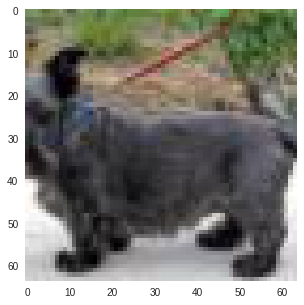

In [126]:
predict_validation(trained_model)

 Training set  : 13998 batches = 13998 samples
Validation set : 6000 batches = 6000 samples
[-9.9922156e-01 -7.7842199e-04]
[0.99330944 0.00669062]
[8.344650e-07 9.999991e-01]
Mismatch case
[9.9999917e-01 8.6639068e-07]


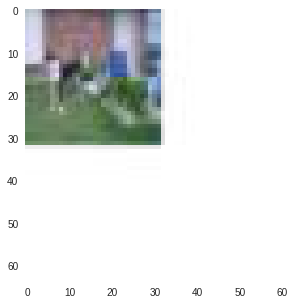

In [128]:
predict_validation(trained_model)

 Training set  : 13998 batches = 13998 samples
Validation set : 6000 batches = 6000 samples
[0.8886944  0.11130559]
Mismatch case
[0.11130556 0.8886944 ]


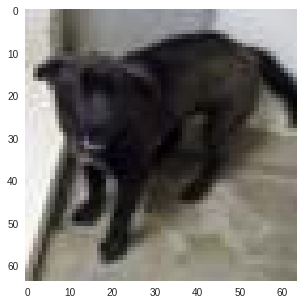

In [131]:
predict_validation(trained_model)

 Training set  : 13998 batches = 13998 samples
Validation set : 6000 batches = 6000 samples
[-9.9999988e-01 -1.2262228e-07]
[9.9999279e-01 7.2717667e-06]
[3.385544e-05 9.999662e-01]
Mismatch case
[9.9996614e-01 3.3823620e-05]


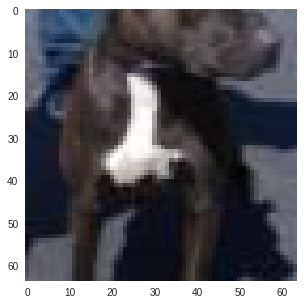

In [136]:
predict_validation(trained_model)

 Training set  : 13998 batches = 13998 samples
Validation set : 6000 batches = 6000 samples
Mismatch case
[9.993862e-01 6.138041e-04]


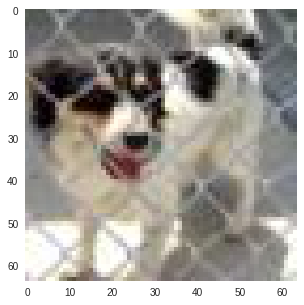

In [138]:
predict_validation(trained_model)

 Training set  : 13998 batches = 13998 samples
Validation set : 6000 batches = 6000 samples
Equally likely case


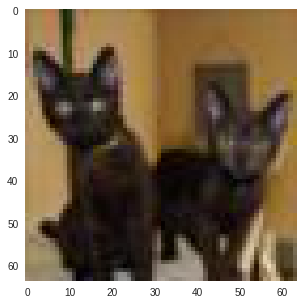

In [64]:
predict_validation(trained_model)

 Training set  : 13998 batches = 13998 samples
Validation set : 6000 batches = 6000 samples
Equally likely case


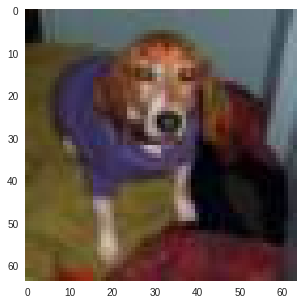

In [65]:
predict_validation(trained_model)

 Training set  : 13998 batches = 13998 samples
Validation set : 6000 batches = 6000 samples
Equally likely case


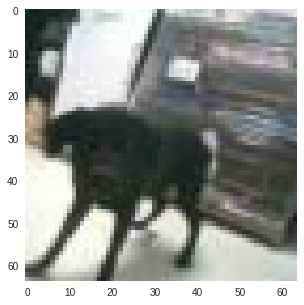

In [66]:
predict_validation(trained_model)

 Training set  : 13998 batches = 13998 samples
Validation set : 6000 batches = 6000 samples
Equally likely case


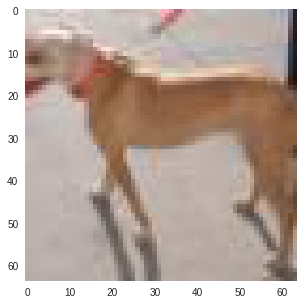

In [67]:
predict_validation(trained_model)

 Training set  : 13998 batches = 13998 samples
Validation set : 6000 batches = 6000 samples
Equally likely case


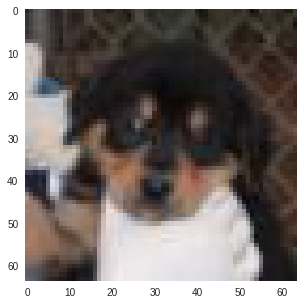

In [68]:
predict_validation(trained_model)

 Training set  : 13998 batches = 13998 samples
Validation set : 6000 batches = 6000 samples
Equally likely case
[0.51991314 0.48008692]


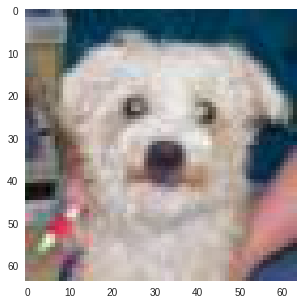

In [71]:
predict_validation(trained_model)

 Training set  : 13998 batches = 13998 samples
Validation set : 6000 batches = 6000 samples
Equally likely case
[0.5357344  0.46426553]


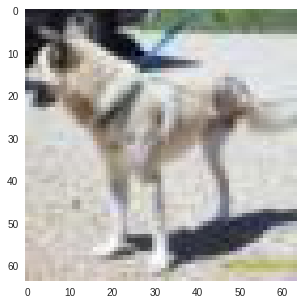

In [72]:
predict_validation(trained_model)

 Training set  : 13998 batches = 13998 samples
Validation set : 6000 batches = 6000 samples
Equally likely case
[0.44204158 0.5579585 ]


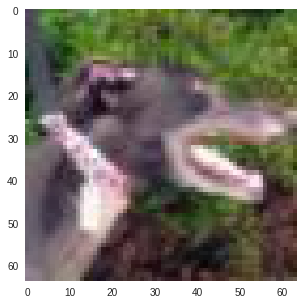

In [73]:
predict_validation(trained_model)

 Training set  : 13998 batches = 13998 samples
Validation set : 6000 batches = 6000 samples
Equally likely case
[0.4311369 0.5688631]


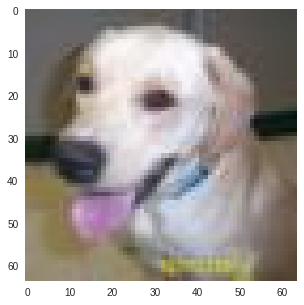

In [74]:
predict_validation(trained_model)

 Training set  : 13998 batches = 13998 samples
Validation set : 6000 batches = 6000 samples
Equally likely case
[0.43519056 0.56480944]


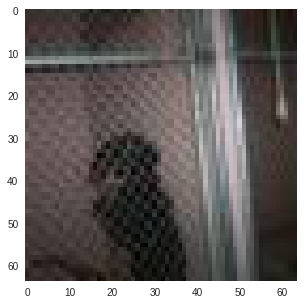

In [77]:
predict_validation(trained_model)

 Training set  : 13998 batches = 13998 samples
Validation set : 6000 batches = 6000 samples
Equally likely case
[0.4151767  0.58482337]


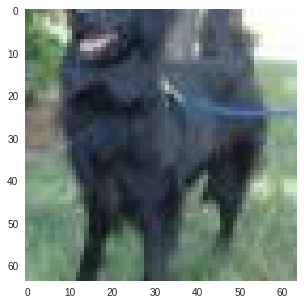

In [78]:
predict_validation(trained_model)

 Training set  : 13998 batches = 13998 samples
Validation set : 6000 batches = 6000 samples
Equally likely case
[0.42938304 0.57061696]


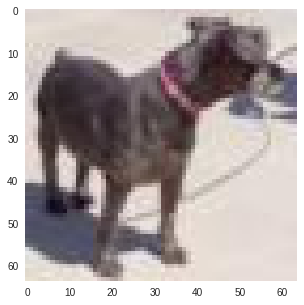

In [79]:
predict_validation(trained_model)

 Training set  : 13998 batches = 13998 samples
Validation set : 6000 batches = 6000 samples
Equally likely case
[0.40389648 0.59610355]


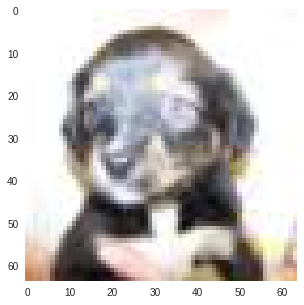

In [81]:
predict_validation(trained_model)

 Training set  : 13998 batches = 13998 samples
Validation set : 6000 batches = 6000 samples
Equally likely case
[0.46324465 0.5367553 ]


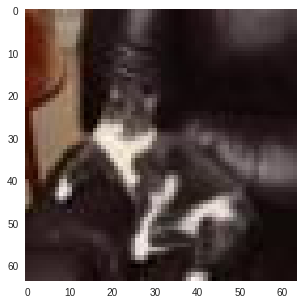

In [85]:
predict_validation(trained_model)

 Training set  : 13998 batches = 13998 samples
Validation set : 6000 batches = 6000 samples
Equally likely case
[0.469285  0.5307149]


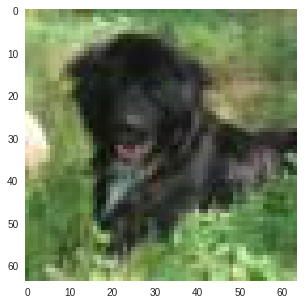

In [90]:
predict_validation(trained_model)

 Training set  : 13998 batches = 13998 samples
Validation set : 6000 batches = 6000 samples
Equally likely case
[0.5066844  0.49331552]


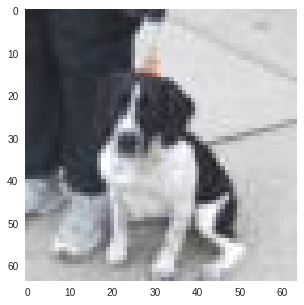

In [91]:
predict_validation(trained_model)

 Training set  : 13998 batches = 13998 samples
Validation set : 6000 batches = 6000 samples
Equally likely case
[0.4749478 0.5250522]


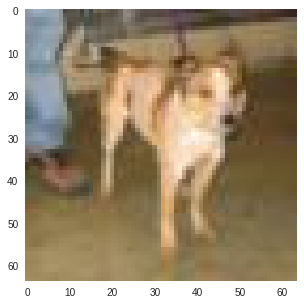

In [92]:
predict_validation(trained_model)

# Section 3 : SUBMISSION

In [0]:
result = predict_submission(model,"resnet34")

In [0]:
#!kaggle competitions submit -c ift6135h19 -f results/submission.csv -m "Message"